# **Part 2: Machine Learning**

# CHALLENGE : predict conversions 🏆🏆

# Import libraries

In [ ]:
!pip install catboost


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Choose necessary variables

In [ ]:
data = pd.read_csv('/content/sample_data/conversion_data_train.csv')
data = data[data['age'] <= 100]
data = data.sample(22000)

In [ ]:
target_variable = 'converted'
Y = data.loc[:, target_variable]

Here we want to check which variables we will further use to test our models. We know from EDA that total_pages_visited seems the most important variable. So we will try to train our model with only this variable, check the f1 score for the train and test, and then add other variables one by one to see if they improve the f1 scores or not. We first add new_user then age, which seemed the most important after the number of pages visited. In each case, we define a new list of features, then a list of numeric_indices and a list of categorical_indices. Then we define the X dataset to work with.

In [ ]:
# Defining features, and features type (numerical/categorical)
features_list = ['total_pages_visited','new_user','age','country','source']
numeric_indices = [0,2]
categorical_indices = [1,3,4]

# Creating several lists of features for our variable study (1 variable, then 2, then 3... then 5)
features_lists = [features_list[:i+1] for i in range(len(features_list))]

# Locate the X dataset in each subset
X_list = [data.loc[:, sublist] for sublist in features_lists]
print("Dataset with only 1 variable: ")
print(X_list[0])
print("")
print("Dataset with 5 variables :")
print(X_list[4])
print("")

# Numeric and categorical indices for each subset
numeric_indices_list = [[i for i in numeric_indices if i in range(len(sublist))] for sublist in features_lists]
categorical_indices_list = [[i for i in categorical_indices if i in range(len(sublist))] for sublist in features_lists]

for i,num,cat in zip(range(5),numeric_indices_list,categorical_indices_list):
    print("Subset with ", i, "variables: Numerical indices: ",num,"; Categorical indices: ",cat)

Dataset with only 1 variable: 
        total_pages_visited
198991                    1
199875                    4
83711                     4
122907                    8
58764                     4
...                     ...
5440                      2
201246                    4
277693                    5
172620                    2
183409                    2

[22000 rows x 1 columns]

Dataset with 5 variables :
        total_pages_visited  new_user  age country  source
198991                    1         0   21      US  Direct
199875                    4         0   18      US     Seo
83711                     4         1   42      UK     Seo
122907                    8         1   19      US     Seo
58764                     4         1   23      UK     Ads
...                     ...       ...  ...     ...     ...
5440                      2         1   23      US     Seo
201246                    4         0   31      US     Seo
277693                    5         1   27   Chi

Here we define the transformers that will be used during preprocessing.

In [ ]:
numeric_transformer = StandardScaler() # for numeric features
categorical_transformer = OneHotEncoder(drop="first") # for categorical features

Now, for each subset (1 or 2 or.. 5 variables), we divide the subset in train and test data, we preprocess them, we run the simplest model (as the target is caterogical), a logistic regression, we make predictions and we assess the model with f1-score (used for categorical target in a regression).

In [ ]:
# Initialize lists to store results
variables = []
f1_train_scores = []
f1_test_scores = []
precision_scores = []
std_deviations = []

for X, numeric_indices, categorical_indices in zip(X_list, numeric_indices_list, categorical_indices_list):

    # Dividing the dataset in train and test (we use stratify as the target variable is not heavenly distributed)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)

    # Applying pipeline on X variables depending on columns
    feature_encoder = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_indices),
            ('num', numeric_transformer, numeric_indices)
        ]
    )
    X_train = feature_encoder.fit_transform(X_train)
    X_test = feature_encoder.transform(X_test)

    # Train the dataset and make predictions
    classifier = LogisticRegression()
    classifier.fit(X_train, Y_train)
    Y_train_pred = classifier.predict(X_train)
    Y_test_pred = classifier.predict(X_test)

    # Calculate scores and precision
    f1_train = np.round(f1_score(Y_train, Y_train_pred), 4)
    f1_test = np.round(f1_score(Y_test, Y_test_pred), 4)
    scores = cross_val_score(classifier, X_train, Y_train, cv=10)
    precision = np.round(scores.mean(), 4)
    std_dev = np.round(scores.std(), 6)

    # Store results in lists
    variables.append(len(numeric_indices) + len(categorical_indices))
    f1_train_scores.append(f1_train)
    f1_test_scores.append(f1_test)
    precision_scores.append(precision)
    std_deviations.append(std_dev)

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
    'Variables': variables,
    'F1 Score (Train)': f1_train_scores,
    'F1 Score (Test)': f1_test_scores,
    'Precision': precision_scores,
    'Standard Deviation': std_deviations
})

print(results_df)

   Variables  F1 Score (Train)  F1 Score (Test)  Precision  Standard Deviation
0          1            0.7102           0.6984     0.9830            0.002237
1          2            0.7390           0.7481     0.9844            0.001846
2          3            0.7559           0.7424     0.9850            0.001750
3          4            0.7722           0.7576     0.9860            0.001747
4          5            0.7760           0.7727     0.9863            0.001702


Every variable added to total_pages_visited is improving the f1-score of the train and test sets. So we confirm that we will use the 5 of them when testing our models later.

# Baseline Logistic Regression

Now, we redefine the final dataset (all 5 features taken into account) and we develop the best logistic regression possible using a gridsearch.

In [ ]:
# Re-defining the dataset with the option chosen: 5 variables
features_list = ['total_pages_visited','new_user','age','country','source']
numeric_indices = [0,2]
categorical_indices = [1,3,4]
X = data.loc[:, features_list]
# I don't need to redefine Y and repreprocess it
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

feature_encoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),
        ('num', numeric_transformer, numeric_indices)
    ]
)
X_train = feature_encoder.fit_transform(X_train)
X_test = feature_encoder.transform(X_test)

In [ ]:
model_baseline =[
     {
        'name': 'Logistic Regression',
        'model': LogisticRegression(),
        'params': {}
    },

    {
        'name': 'Logistic Regression L1L2',
        'model': LogisticRegression(),
        'params':
            {
            'penalty': ['l1','l2'],                                     # Regularization type
            'C': [0.01, 0.1, 1.0, 10.0, 20, 30,40],                     # Inverse of regularization strength
            'solver': ['liblinear'],                                    # Optimization algorithm for smaller datasets
            'max_iter': [100, 200, 500, 1000, 5000],                    # Maximum number of iterations to converge
            'tol': [1e-3, 1e-4, 1e-5],                                  # Tolerance for stopping criteria
            }
    },

    {
    'name': 'Logisn L2',
    'model': LogisticRegression(),
    'params':tic Regressio
        {
        'penalty': ['l2'],                                              # Regularization type
        'C': [1.0 , 4.0 , 8.0 ,10.0 , 11.0 , 13.0 ,15 ,20 ],            # Inverse of regularization strength
        'solver': ['newton-cg', 'sag', 'lbfgs' ],                       # Optimization algorithm for smaller datasets
        'max_iter': [100, 200, 500, 1000, 5000],                        # Maximum number of iterations to converge
        'tol': [1e-3, 1e-4, 1e-5],                                      # Tolerance for stopping criteria
        }
    },

    {
      'name': 'Logistic Regression ELASTICNET',
      'model': LogisticRegression(),
      'params':
      {
          'penalty': ['elasticnet'],
          'C': [0.01,0.1,0.2,0.3,0.4, 0.5,0.6,0.7,0.8,0.9 ,1.0],
          'solver': ['saga'],
          'max_iter': [100, 200, 500, 1000, 5000],
          'tol': [1e-3, 1e-4, 1e-5],
          'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Specify l1_ratio values here
      }
    }

]


We can have a look at our gridsearch in order to see what were the best parameters.

In [ ]:
results = []

# Iterate over models, doing a gridsearch for choosing the best params for each model.
for model in model_baseline:
    model_name = model['name']
    model_type = model['model']
    params = model['params']
    grid_search = GridSearchCV(model_type, params, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, Y_train)

    # Evaluation and storage of performance in a variable "results"
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(best_params)

    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    f1_train = np.round(f1_score(Y_train, train_preds), 7)
    f1_test = np.round(f1_score(Y_test, test_preds), 7)

    accuracy_train = accuracy_score(Y_train, train_preds)
    accuracy_test = accuracy_score(Y_test, test_preds)
    recall = recall_score(Y_test, test_preds)
    auc_roc = roc_auc_score(Y_test, test_preds)

    results.append({'Model': model['name'],
                'F1 Train': f1_train,
                'F1 Test': f1_test,
                'Train Accuracy': accuracy_train,
                'Test Accuracy': accuracy_test,
                'Recall': recall,
                'AUC-ROC': auc_roc,
                'Best Model': best_model,
                'Best Params': best_params,
                'Train Preds': train_preds,
                'Test Preds': test_preds,

                })

{}
{'C': 10.0, 'max_iter': 5000, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
{'C': 4.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.001}
{'C': 0.9, 'l1_ratio': 0.9, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.001}


In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.loc[:,['Model','F1 Train', 'F1 Test', 'Train Accuracy','Test Accuracy', 'Recall', 'AUC-ROC']]
sorted_results_df = results_df.sort_values(by='F1 Test', ascending=False)
print(sorted_results_df)

                            Model  F1 Train   F1 Test  Train Accuracy  \
1        Logistic Regression L1L2  0.776119  0.775194        0.986364   
2          Logistic Regression L2  0.776119  0.770428        0.986364   
3  Logistic Regression ELASTICNET  0.775701  0.770428        0.986364   
0             Logistic Regression  0.775281  0.767442        0.986364   

   Test Accuracy    Recall   AUC-ROC  
1       0.986818  0.675676  0.836662  
2       0.986591  0.668919  0.833284  
3       0.986591  0.668919  0.833284  
0       0.986364  0.668919  0.833166  


Here we notice that the simple logistic regression has the lowest F1 score test compare to the regularized logistic regression.

# Testing more models

Now that we have a baseline, the idea is to test more models to see if we can improve the f1 score.

In [ ]:
# Models to be tested

models = [
    {
        'name': 'SVM Linear',
        'model': SVC(kernel='linear', probability=True),
        'params': {}
    },
    {
        'name': 'SVM RBF',
        'model': SVC(kernel='rbf', probability=True),
        'params': {}
    },
    {
        'name': 'SVM Poly (3)',
        'model': SVC(kernel='poly', degree=3, probability=True),
        'params': {}
    },
    {
        'name': 'Decision Tree Entropy',
        'model': DecisionTreeClassifier(criterion="entropy"),
        'params': {
        'max_depth': [4, 6, 8, 10],
        'min_samples_leaf': [1, 2, 5],
        'min_samples_split': [2, 4, 8]
        }
    },
    {
        'name': 'Decision Tree Gini',
        'model': DecisionTreeClassifier(criterion="gini"),
        'params': {
        'max_depth': [4, 6, 8, 10],
        'min_samples_leaf': [1, 2, 5],
        'min_samples_split': [2, 4, 8]
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(),
        'params': {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [1, 2, 4, 8],
        'min_samples_leaf': [1, 2, 5],
        'min_samples_split': [2, 4, 8]
        }
    },
    {
        'name': 'XGBoost',
        'model': XGBClassifier(),
        'params': {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.01],
        'max_depth': [4, 5],
        'min_child_weight': [1],

        }
    },
    {
        'name': 'CatBoost',
        'model': CatBoostClassifier(),
        'params': {
        'n_estimators': [1000],
        'learning_rate': [0.1],
        'depth': [6],
        }
    },
]


In [ ]:
# Iterate over models, doing a gridsearch for choosing the best params for each model.
for model in models:
    model_name = model['name']
    model_type = model['model']
    params = model['params']
    grid_search = GridSearchCV(model_type, params, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, Y_train)

    # Evaluation and storage of performance in a variable "results"
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_


    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    f1_train = np.round(f1_score(Y_train, train_preds), 7)
    f1_test = np.round(f1_score(Y_test, test_preds), 7)

    accuracy_train = accuracy_score(Y_train, train_preds)
    accuracy_test = accuracy_score(Y_test, test_preds)
    recall = recall_score(Y_test, test_preds)
    auc_roc = roc_auc_score(Y_test, test_preds)

    results.append({'Model': model['name'],
                'F1 Train': f1_train,
                'F1 Test': f1_test,

                'Train Accuracy': accuracy_train,
                'Test Accuracy': accuracy_test,
                'Recall': recall,
                'AUC-ROC': auc_roc,
                'Best Model': best_model,
                'Best Params': best_params,
                'Train Preds': train_preds,
                'Test Preds': test_preds,
                })

In [ ]:
# Results storage in a DataFrame

results_df = pd.DataFrame(results)
results_df = results_df.loc[:,['Model','F1 Train', 'F1 Test', 'Train Accuracy','Test Accuracy', 'Recall', 'AUC-ROC']]
sorted_results_df = results_df.sort_values(by='F1 Test', ascending=False)
print(sorted_results_df)

                             Model  F1 Train   F1 Test  Train Accuracy  \
1         Logistic Regression L1L2  0.776119  0.775194        0.986364   
2           Logistic Regression L2  0.776119  0.770428        0.986364   
3   Logistic Regression ELASTICNET  0.775701  0.770428        0.986364   
4                       SVM Linear  0.776626  0.768628        0.986534   
0              Logistic Regression  0.775281  0.767442        0.986364   
10                         XGBoost  0.794007  0.746032        0.987500   
7            Decision Tree Entropy  0.788104  0.736434        0.987045   
5                          SVM RBF  0.762745  0.721311        0.986250   
9                    Random Forest  0.780115  0.717742        0.986932   
6                     SVM Poly (3)  0.761531  0.716049        0.986193   
8               Decision Tree Gini  0.791783  0.698795        0.987330   
11                        CatBoost  0.890696  0.681481        0.993125   

    Test Accuracy    Recall   AUC-ROC

The best model is the logistic regression L1L2 even if we see that the regularized logistic regression L2 and ELASTICNET have similar F1 test score.

# Ensemble learning methods

We already tuned the logistic regression with the gridsearch. It seems that we don't have overfitting (test and train are very close), but now, we can try to increase the f1-scores even more using boosting and bagging ensemble learning methods. We will also try voting and stacking ensemble methods where we will use the top3 model resulted from the previous hyperparameter tuning.

In [ ]:
# Retrieve the top3 models tested
top3_models = sorted_results_df['Model'].head(3).tolist()
print("Top 3 models: ",top3_models)

# Sort result, retrieve the hyperparameters and model name
sorted_results = sorted(results, key=lambda x: x['F1 Test'], reverse=True)
top3_result = [result for result in sorted_results if result['Model'] in top3_models]
base_estimators= [model['Best Model'] for model in top3_result]
model_name= [model['Model'] for model in top3_result]


Top 3 models:  ['Logistic Regression L1L2', 'Logistic Regression L2', 'Logistic Regression ELASTICNET']


In [ ]:
top3_result

[{'Model': 'Logistic Regression L1L2',
  'F1 Train': 0.7761194,
  'F1 Test': 0.7751938,
  'Train Accuracy': 0.9863636363636363,
  'Test Accuracy': 0.9868181818181818,
  'Recall': 0.6756756756756757,
  'AUC-ROC': 0.8366619206224097,
  'Best Model': LogisticRegression(C=10.0, max_iter=5000, penalty='l1', solver='liblinear',
                     tol=0.001),
  'Best Params': {'C': 10.0,
   'max_iter': 5000,
   'penalty': 'l1',
   'solver': 'liblinear',
   'tol': 0.001},
  'Train Preds': array([0, 0, 0, ..., 0, 0, 0]),
  'Test Preds': array([0, 0, 0, ..., 0, 0, 0])},
 {'Model': 'Logistic Regression L2',
  'F1 Train': 0.7761194,
  'F1 Test': 0.770428,
  'Train Accuracy': 0.9863636363636363,
  'Test Accuracy': 0.9865909090909091,
  'Recall': 0.668918918918919,
  'AUC-ROC': 0.8332835422440314,
  'Best Model': LogisticRegression(C=4.0, solver='newton-cg', tol=0.001),
  'Best Params': {'C': 4.0,
   'max_iter': 100,
   'penalty': 'l2',
   'solver': 'newton-cg',
   'tol': 0.001},
  'Train Preds': 

In [ ]:
ensemble_methods = [
    {'name': 'Voting_top3models', 'model': VotingClassifier,
     'params': {'estimators': [(model['Model'], model['Best Model']) for model in top3_result],
                'voting': 'soft'}
    },
    {'name': 'Bagging_20x_'+ model_name[0],
     'model': BaggingClassifier,
     'params': {'base_estimator': base_estimators[0],
                'n_estimators': 20}
    },
        {'name': 'Bagging_20x_'+ model_name[1],
     'model': BaggingClassifier,
     'params': {'base_estimator': base_estimators[1],
                'n_estimators': 20}
    },
    {'name': 'Bagging_20x_'+ model_name[2],
     'model': BaggingClassifier,
     'params': {'base_estimator': base_estimators[2],
                'n_estimators': 20}
    },
    {'name': 'Bagging_100x_' + model_name[0],
     'model': BaggingClassifier,
     'params': {'base_estimator': base_estimators[0],
                'n_estimators': 100}
    },
    {'name': 'Bagging_100x_' + model_name[1],
     'model': BaggingClassifier,
     'params': {'base_estimator': base_estimators[1],
                'n_estimators': 100}
    },
    {'name': 'Bagging_100x_' + model_name[2],
     'model': BaggingClassifier,
     'params': {'base_estimator': base_estimators[2],
                'n_estimators': 100}
    },
    {'name': 'Adaboosting_20x_'+ model_name[0],
     'model': AdaBoostClassifier,
     'params': {'base_estimator': base_estimators[0],
                'n_estimators': 20}
    },
    {'name': 'Adaboosting_20x_'+ model_name[1],
     'model': AdaBoostClassifier,
     'params': {'base_estimator': base_estimators[1],
                'n_estimators': 20}
    },
    {'name': 'Adaboosting_20x_'+ model_name[2],
     'model': AdaBoostClassifier,
     'params': {'base_estimator': base_estimators[2],
                'n_estimators': 20}
    },
    {'name': 'Adaboosting_100x_top1_'+ model_name[0],
     'model': AdaBoostClassifier,
     'params': {'base_estimator': base_estimators[0],
                'n_estimators': 100}
    },
    {'name': 'Adaboosting_100x_top1_'+ model_name[1],
     'model': AdaBoostClassifier,
     'params': {'base_estimator': base_estimators[1],
                'n_estimators': 100}
    },
    {'name': 'Adaboosting_100x_top1_'+ model_name[2],
     'model': AdaBoostClassifier,
     'params': {'base_estimator': base_estimators[2],
                'n_estimators': 100}
    },

    {'name': 'Stacking_top3_models',
     'model': StackingClassifier,
     'params': {'estimators': [
        ('Staking'+ model_name[0], base_estimators[0]),
        ('Staking'+ model_name[1], base_estimators[1]),
        ('Staking'+ model_name[2], base_estimators[2])
    ]}
    },
]

In [ ]:


for ensemble in ensemble_methods:
    ensemble_name = ensemble['name']
    ensemble_type = ensemble['model']
    params = ensemble.get('params', {})

    ensemble_full_model = ensemble_type(**params)
    ensemble_full_model.fit(X_train, Y_train)

    train_preds = ensemble_full_model.predict(X_train)
    test_preds = ensemble_full_model.predict(X_test)
    f1_train = np.round(f1_score(Y_train, train_preds), 4)
    f1_test = np.round(f1_score(Y_test, test_preds), 4)
    accuracy_train = accuracy_score(Y_train, train_preds)
    accuracy_test = accuracy_score(Y_test, test_preds)
    recall = recall_score(Y_test, test_preds)
    auc_roc = roc_auc_score(Y_test, test_preds)

    results.append({
        'Model': ensemble_name,
        'F1 Train': f1_train,
        'F1 Test': f1_test,
        # 'Precision': precision,
        # 'Std Dev': std_dev,
        'Train Accuracy': accuracy_train,
        'Test Accuracy': accuracy_test,
        'Recall': recall,
        'AUC-ROC': auc_roc,
        'Best Model': ensemble_full_model,
        'Best Params': params,
        'Train Preds': train_preds,
        'Test Preds': test_preds
        })

In [ ]:
# Results storage in a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.iloc[:,:7]
sorted_results_df = results_df.sort_values(by='F1 Test', ascending=False)
print(sorted_results_df)

                                                   Model  F1 Train   F1 Test  \
14                    Bagging_20x_Logistic Regression L2  0.773200  0.784600   
20                Adaboosting_20x_Logistic Regression L2  0.768100  0.780300   
23          Adaboosting_100x_top1_Logistic Regression L2  0.771200  0.778600   
1                               Logistic Regression L1L2  0.776119  0.775194   
2                                 Logistic Regression L2  0.776119  0.770428   
3                         Logistic Regression ELASTICNET  0.775701  0.770428   
13                  Bagging_20x_Logistic Regression L1L2  0.775000  0.770400   
12                                     Voting_top3models  0.776100  0.770400   
18           Bagging_100x_Logistic Regression ELASTICNET  0.776400  0.770400   
17                   Bagging_100x_Logistic Regression L2  0.775000  0.770400   
4                                             SVM Linear  0.776626  0.768628   
0                                    Log

After the ensemble learning methods show better performance compare to the regularized logistic regression and the other model, the f1_test increased slightly.
Let's have a look at ROC curves, Preicsion-Recall curves and confusion matrices to see better the effect of boosting and bagging on the logistic regression.

Top 3 results from ensembling methods:
- Bagging_20x_Logistic Regression L2 F1_test = 0.7846
- Adaboosting_20x_Logistic Regression L2 with F1_test= 0.7803
- Adaboosting_100x_top1_Logistic Regression L2 with F1_test= 0.7786

In [ ]:
# Select the top 5 models based on F1 Test score
top5_models = sorted(results, key=lambda x: x['F1 Test'], reverse=True)[:5]

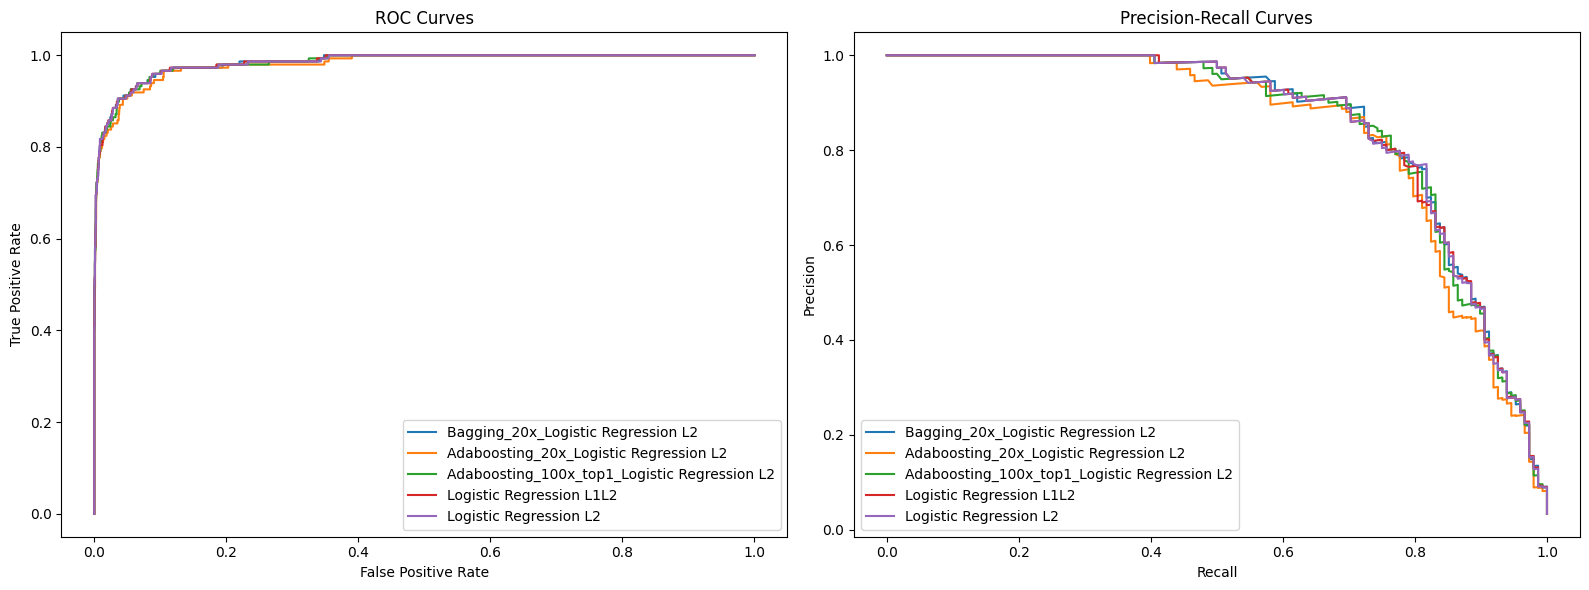

In [ ]:
from sklearn.metrics import roc_curve, auc,precision_recall_curve


plt.figure(figsize=(16, 6))

# ROC Curves
plt.subplot(1, 2, 1)
for model_result in top5_models:
    model_name = model_result['Model']
    model = model_result['Best Model'] # retrieve model
    test_probs = model.predict_proba(X_test)[:, 1] # predict probabilities
    fpr, tpr, _ = roc_curve(Y_test, test_probs) # calculates the false positive rates and true positive rates with the function "roc_curve" (we put use "_" to omit the 3rd output of the function "roc_curve" which is the threshold)
    roc_auc = auc(fpr, tpr) # calculates the area under the ROC Curve (AUC-ROC) using the auc function
    plt.plot(fpr, tpr, label=f'{model_name}') # subplot title

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")

# Precision-Recall Curves
plt.subplot(1, 2, 2)
for model_result in top5_models:
    model_name = model_result['Model']
    model = model_result['Best Model']
    test_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(Y_test, test_probs) # the "_" is to omit the threshold which is the 3rd output of the function precision_recall_curve
    plt.plot(recall, precision, label=f'{model_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

The 2 graphs show that the 5 methods give very similar results for ROC, precision and recall.

For the ROC curve, a perfect model would pass by the top left corner meaning all positives are true positives and negatives are true negatives. We are very close to this.

For the precision and recall curve, in general, we want a good balance between those 2. In our case, we want to know if a user will subscribe or not, and this variable is very imbalanced (only few converted users).

So we might in that case prefer a good recall than a good precision, meaning we will predict really well that a user subscribe even though precision won't be perfect (we might predict that a user subscribe when it is not).

Here, it's just an analysis of profiles of users suscribing so the company won't make money if making false positives. So the best recall obtained is actually with adaboosting20.

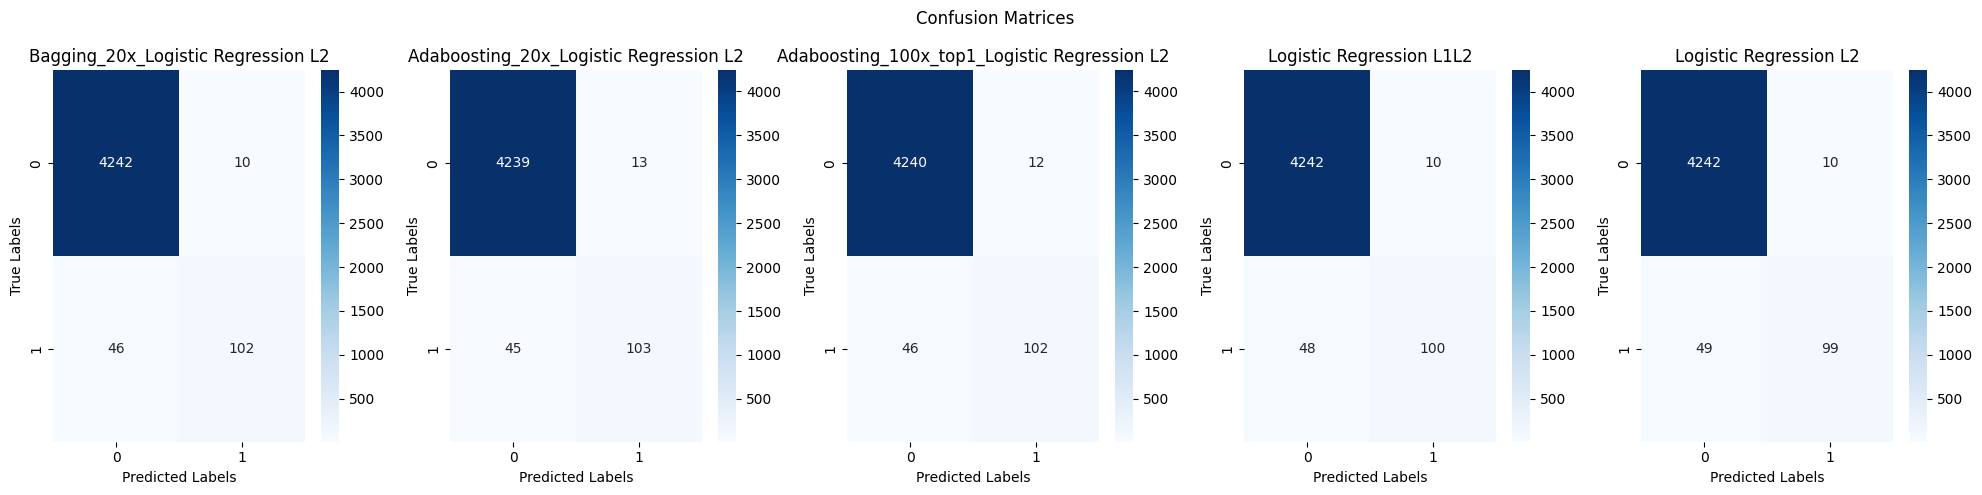

In [ ]:
plt.figure(figsize=(20, 5))

# Plot Confusion Matrices
for i, model_result in enumerate(top5_models, 1):
    model_name = model_result['Model']
    test_preds = model_result['Test Preds']
    cm = confusion_matrix(Y_test, test_preds)

    plt.subplot(1, 5, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f'{model_name}', fontsize=12)

plt.suptitle("Confusion Matrices")
plt.tight_layout()
plt.show()


# Add the test_dataset and make predictions

In [ ]:
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

Let's retrieve the best models from the whole project.

In [ ]:
top5_models_names = sorted_results_df['Model'].head(5).tolist()
final_results = []

Now, we fit the models on the new larger dataset, retrieve f1 score and other useful metrics. Finally, we take the file "conversion_data_test" that we are asked to predict, preprocess it the same way we did with the train_dataset, then we can apply our model on it and predict the labels. We save all models in the folder "Models/final_models" and all predictions in the folder "Predictions".

In [ ]:
%%time

for model_name in top5_models_names:
    # Retrieve the model information in the results list
    model_info = next(model for model in results if model['Model'] == model_name)
    best_model = model_info['Best Model']

    # Fit the best model on the new dataset (X, Y)
    best_model.fit(X, Y)

    # Make predictions on the new dataset
    Y_pred = best_model.predict(X)

    # Calculate evaluation metrics on the new dataset and store them
    f1_final = np.round(f1_score(Y, Y_pred), 4)
    accuracy_final = accuracy_score(Y, Y_pred)
    recall_final = recall_score(Y, Y_pred)
    auc_roc_final = roc_auc_score(Y, Y_pred)
    final_results.append({
        'Model': model_name,
        'F1 Score': f1_final,
        'Accuracy': accuracy_final,
        'Recall': recall_final,
        'AUC-ROC': auc_roc_final
    })

    # Saving model
    joblib.dump(best_model, f'/content/drive/MyDrive/Colab Notebooks/Bloc_3_ML-main/PROJECT_Conversion/Models/final_models/{model_name}.joblib')

    # Predict the the file "conversion_data_test"
    data_without_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bloc_3_ML-main/PROJECT_Conversion/Data/conversion_data_test.csv') # read file
    X_without_labels = data_without_labels.loc[:, features_list].values
    X_without_labels = feature_encoder.transform(X_without_labels) # preprocessing
    data = {'converted': best_model.predict(X_without_labels)} # predict
    Y_predictions = pd.DataFrame(columns=['converted'], data=data) # one column "converted", no index
    prediction_filename = f'/content/drive/MyDrive/Colab Notebooks/Bloc_3_ML-main/PROJECT_Conversion/Predictions/{model_name}_predictions.csv'
    Y_predictions.to_csv(prediction_filename, index=False) # save into csv file

In [ ]:
# Results storage in a DataFrame
final_results_df = pd.DataFrame(final_results)
sorted_final_results_df = final_results_df.sort_values(by='F1 Score', ascending=False)
print(sorted_final_results_df)

                                          Model  F1 Score  Accuracy    Recall  \
0            Bagging_20x_Logistic Regression L2    0.7773  0.986455  0.701754   
3                      Logistic Regression L1L2    0.7755  0.986318  0.701754   
4                        Logistic Regression L2    0.7746  0.986273  0.700405   
2  Adaboosting_100x_top1_Logistic Regression L2    0.7713  0.985955  0.703104   
1        Adaboosting_20x_Logistic Regression L2    0.7675  0.985818  0.695007   

    AUC-ROC  
0  0.849066  
3  0.848996  
4  0.848321  
2  0.849459  
1  0.845481  
